# 基于backtrader的多因子选股代码实现

> 山东大学（威海）数学与统计学院 2018级数据科学班 

> 孙易泽 吴锦程 詹沛

导入程序所需要的的包，主要包括quantmind和backtrader：

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
from tabulate import tabulate
import time
import quantmind as qm

## 1.定义策略

首先我们定义接下来程序中使用到的类。在往backtrader添加数据的过程中，open, high, low, close, volume为BackTrader中默认的数据项，其余数据无法直接添加，因此需要对BackTrader中的数据加载模块进行修改。这里定义stkData类：

In [2]:
class stkData(bt.feeds.PandasData):
    lines = ('total_mv_score','ps_score','pe_score','turnover_rate_score', 'flow_mv_score')
    params = dict(
        turnover_rate_score=-1,
        pe_score=-1,
        ps_score=-1,
        total_mv_score=-1,
        flow_mv_score=-1,
        dtformat='%Y-%m-%d',
        openinterest=-1
    )

定义策略分析指标：

In [3]:
class TradeAnalyzer(bt.Analyzer):
    def get_analysis(self):
        return self.trades

    def __init__(self):
        self.trades = []
        self.cumprofit = 0.0
        
    def notify_trade(self, trade):
        if trade.isclosed:
            brokervalue = self.strategy.broker.getvalue()
            dir = 'sell'
            if trade.history[0].event.size > 0: dir = 'buy'

            pricein = trade.history[len(trade.history) - 1].status.price
            priceout = trade.history[len(trade.history) - 1].event.price
            datein = bt.num2date(trade.history[0].status.dt)
            dateout = bt.num2date(trade.history[len(trade.history) - 1].status.dt)
            if trade.data._timeframe >= bt.TimeFrame.Days:
                datein = datein.date()
                dateout = dateout.date()

            pcntchange = 100 * priceout / pricein - 100
            pnl = trade.history[len(trade.history) - 1].status.pnlcomm
            pnlpcnt = 100 * pnl / brokervalue
            barlen = trade.history[len(trade.history) - 1].status.barlen
            pbar = pnl / (barlen+1)
            self.cumprofit += pnl

            size = value = 0.0
            for record in trade.history:
                if abs(size) < abs(record.status.size):
                    size = record.status.size
                    value = record.status.value

            highest_in_trade = max(trade.data.high.get(ago=0, size=barlen + 1))
            lowest_in_trade = min(trade.data.low.get(ago=0, size=barlen + 1))
            hp = 100 * (highest_in_trade - pricein) / pricein
            lp = 100 * (lowest_in_trade - pricein) / pricein
            if dir == 'buy':
                mfe = hp
                mae = lp
            if dir == 'sell':
                mfe = -lp
                mae = -hp

            self.trades.append({'ref': trade.ref, 'ticker': trade.data._name,
                                '买入日期': datein, '买入价格': pricein, '卖出日期': dateout, '卖出价格': priceout,
                                'chng%': round(pcntchange, 2), 'pnl': pnl, 'pnl%': round(pnlpcnt, 2),
                                'size': size, 'value': value, 'cumpnl': self.cumprofit,
                                'nbars': barlen, 'pnl/bar': round(pbar, 2),
                                'mfe%': round(mfe, 2), 'mae%': round(mae, 2)})

创建策略，继承backtrader的策略类。选取股票的pe_ttm（市盈率）,ps_ttm（市销率）,total mv(总市值),turnover rate（换手率），flow_mv（流通市值）五项因子作为决策的因素，并对这些因子进行打分，按照不同的比重加权相加,排序并选择排名靠前的股票，根据打分得出的排序来进行股票买入和卖出。

对于加权权重，选取等权加权的方法进行记分。

In [4]:
class stkStrategy(bt.Strategy):
    params = dict(
        weight_pe=0.2,
        weight_ps=0.2,
        weight_mv=0.2,
        weight_to=0.2,
        weight_fl=0.2,
        max_hold_num =20,
        trail_percent=1,
        limit_percent = 1
    )

    def __init__(self):
        self.stk = self.datas[1:]# 去掉第一个指数
        self.score = dict()
        self.hold_stk = []
        self.ranks = []
        self.orders = []    # 所有订单列表
        self.buy_orders = [] # 执行中的buy订单
        self.profit = []
        self.fee = 0.0  # 合计费用 (佣金+印花税)

        for o in self.stk:
            self.score[o] = self.p.weight_pe*o.pe_score(0) + self.p.weight_ps*o.ps_score(0) +\
            self.p.weight_mv*o.total_mv_score(0)+self.p.weight_to*o.turnover_rate_score(0)+\
            self.p.weight_fl*o.flow_mv_score(0)

    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))

    def prenext(self):
        self.log('prenext()')
        self.next()

    def nextstart(self):
        self.log('nextstart()')
        self.next()

    def next(self):
        self.curDate = self.data0.datetime.date(0)
        self.log('-------------------------- next -------------------------')
        self.hold_stk = [b for b, pos in self.getpositions().items() if pos]
        self.log('总资产:%.2f元(空闲:%.2f元), 总费用:%.2f元' % (self.broker.getvalue(), self.broker.getcash(), self.fee))
        self.profit.append(self.broker.getvalue())
        self.stk.sort(key=lambda stk: self.score[stk][0], reverse=True)
        self.ranks = self.stk[0:self.p.max_hold_num]
        for stk in [stk for stk in self.hold_stk if stk not in self.ranks]:
            self.log('- 调出(止损/止盈): [%s],' % (stk._name))
            order = self.sell(data=stk,
                              size=self.getposition(stk).size)
            self.orders.append(order)
        for stk in [stk for stk in self.ranks if stk not in self.hold_stk]:
            if  self.curDate == stk.datetime.date(0):
                target_money = (self.broker.getvalue() * 0.98) / (self.p.max_hold_num)
                target_size = int(target_money / stk.close[0] )
                limit_price = stk.close[0] * (1.0 - self.p.limit_percent / 100.0)
                found_order = stk._name in [o.data._name for o in self.orders]
                if (not found_order) :
                    self.log('+ 调入: [%s], %.2f元x%d股=%.2f元, 买入限价:%.2f元，' % (
                        stk._name, stk.close[0], target_size, stk.close[0] * target_size, limit_price,))
                    order = self.buy(data=stk, size=target_size)
                    self.orders.append(order)
                    self.buy_orders.append(order)

    def stop(self):
        self.log('-------------------------- stop -------------------------')
        self.log('最终总资产:%.2f元, 盈利:%.2f元, 总费用:%.2f元,持有方式 最大持有%.2f支 ' % (
            self.broker.getvalue(), self.broker.getvalue() - g_init_cash, self.fee, self.params.max_hold_num))

    def notify_order(self, order):
        need_remove = False
        if order.status in [order.Completed]:
            self.log('-------------------------- notify_order -------------------------')
            self.fee += order.executed.comm
            if order.isbuy():
                self.log(
                    '订单买入: [%s] 买入价:%.2f元, 总价:%.2f元, 费用:%.2f元' %
                    (order.data._name,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm))
            else:  # Sell
                self.log('订单卖出: [%s] 卖出价:%.2f元, 总价:%.2f, 费用:%.2f元' %
                         (order.data._name,
                          order.executed.price,
                          order.executed.price * order.size,
                          order.executed.comm))
            # self.bar_executed = len(self)
            need_remove = True

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消(拒绝): [%s]' % order.data._name)
            need_remove = True

        elif order.status in [order.Expired]:
            self.log('订单过期: [%s]' % order.data._name)
            need_remove = True

        if need_remove:
            # 订单‘部分’执行的情况还需要继续追踪
            for o in self.orders:
                if o.data._name == order.data._name:
                    self.orders.remove(o)
            for o in self.buy_orders:
                if o.data._name == order.data._name:
                    self.buy_orders.remove(o)

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

## 2.准备数据

定义交易开始日和交易结束日：

In [5]:
start_date, end_date = '20190101', '20210101'
g_init_cash = 10000000

读取股票信息并进行筛选：

In [6]:
df_stk = qm.get_stock_list()
df_stk = df_stk[(df_stk['list_date'] <= end_date) & (~(df_stk['name'].str.contains('ST')))]
df_stk = df_stk.head(100)

选取因子并对因子进行打分：分数包括0分，3分，5分，7分，10分五个档次。

In [7]:
stk_data = dict()
for i, stk_row in df_stk.iterrows():
    df_stk_bar = qm.get_bar(stk_row['code'], start_date=start_date, end_date=end_date, freq='1d')
    df_stk_bar['trade_date'] = pd.to_datetime(df_stk_bar.trade_date, format='%Y%m%d')
    df_ind = qm.get_ind(stk_row['code'], start_date=start_date, end_date=end_date,
                        column=['turnover_rate','pe_ttm','ps_ttm','total_mv','flow_mv'])
    df_ind = df_ind.drop(columns=['code', 'name'])
    df_ind['trade_date'] = pd.to_datetime(df_ind.trade_date, format='%Y%m%d')
    
    df1 = pd.merge(df_stk_bar, df_ind, on=['trade_date'])
    df1['pe_ttm'].fillna(-1,inplace=True)
    df1.fillna(method="ffill",inplace=True)
    print('%d 准备数据: [%s(%s)]' % (i + 1, stk_row['name'], stk_row['code']))

    df1.loc[df1['turnover_rate'] >= 20, 'turnover_rate_score'] = 3
    #df1.loc[(12<= df1['turnover_rate']) & (df1['turnover_rate'] <18), 'turnover_rate_score'] = 8
    df1.loc[(12 <= df1['turnover_rate']) & (df1['turnover_rate'] < 20), 'turnover_rate_score'] = 7
    df1.loc[(3 <= df1['turnover_rate']) & (df1['turnover_rate'] < 7), 'turnover_rate_score'] = 5
    df1.loc[(7 <= df1['turnover_rate']) & (df1['turnover_rate'] < 12), 'turnover_rate_score'] = 10
    df1.loc[df1['turnover_rate'] < 3, 'turnover_rate_score'] = 0
    
    df1.loc[(df1['pe_ttm'] >= 100)|(df1['pe_ttm'] < 0), 'pe_score'] = 0
    df1.loc[(60<= df1['pe_ttm']) & (df1['pe_ttm'] < 100), 'pe_score'] = 3
    df1.loc[(25 <= df1['pe_ttm']) & (df1['pe_ttm'] < 60), 'pe_score'] = 5
    df1.loc[(10<= df1['pe_ttm']) & (df1['pe_ttm'] < 25), 'pe_score'] = 10
    #df1.loc[( 25<= df1['pe_ttm']) & (df1['pe_ttm'] < 40), 'pe_score'] =6
    df1.loc[( 0<= df1['pe_ttm']) & (df1['pe_ttm'] < 10), 'pe_score'] =7

    df1.loc[df1['ps_ttm'] >=35, 'ps_score'] = 0
    #df1.loc[(25 <= df1['ps_ttm']) & (df1['ps_ttm'] < 35), 'ps_score'] = 2
    df1.loc[(25 <= df1['ps_ttm']) & (df1['ps_ttm'] < 35), 'ps_score'] = 3
    df1.loc[(12 <= df1['ps_ttm']) & (df1['ps_ttm'] < 25), 'ps_score'] = 5
    df1.loc[(5<= df1['ps_ttm']) & (df1['pe_ttm'] < 12), 'ps_score'] =7
    df1.loc[df1['ps_ttm'] < 5, 'ps_score'] = 10

    df1.loc[df1['total_mv'] >= 50000000, 'total_mv_score'] =3
    #df1.loc[(40000000 <= df1['total_mv']) & (df1['total_mv'] < 50000000), 'total_mv_score'] = 4
    df1.loc[(30000000 <= df1['total_mv']) & (df1['total_mv'] < 50000000), 'total_mv_score'] = 5
    df1.loc[(8000000 <= df1['total_mv']) & (df1['total_mv'] < 30000000), 'total_mv_score'] =7
    df1.loc[(1000000<= df1['total_mv']) & (df1['total_mv'] < 8000000), 'total_mv_score'] = 10
    df1.loc[df1['total_mv'] < 1000000, 'total_mv_score'] = 0
    
    
    df1.loc[df1['flow_mv'] >= 25000000, 'flow_mv_score'] =3
    #df1.loc[(40000000 <= df1['total_mv']) & (df1['total_mv'] < 50000000), 'total_mv_score'] = 4
    df1.loc[(15000000 <= df1['flow_mv']) & (df1['flow_mv'] < 25000000), 'flow_mv_score'] = 5
    df1.loc[(4000000 <= df1['flow_mv']) & (df1['flow_mv'] < 15000000), 'flow_mv_score'] =7
    df1.loc[(500000<= df1['flow_mv']) & (df1['flow_mv'] < 4000000), 'flow_mv_score'] = 10
    df1.loc[df1['flow_mv'] < 500000, 'flow_mv_score'] = 0
    
    
    df1 =df1 [['code','trade_date','open','high','low','close','volume','total_mv_score','ps_score','pe_score','turnover_rate_score','flow_mv_score']]
    df1.drop_duplicates(["trade_date"], keep="last", inplace=True)
    stk_data[stk_row['name'] + '(' + stk_row['code'] + ')'] = df1
np.save('total_stk_data.npy', stk_data)

1 准备数据: [平安银行(000001.SZ)]
2 准备数据: [万科A(000002.SZ)]
3 准备数据: [国华网安(000004.SZ)]
5 准备数据: [深振业A(000006.SZ)]
7 准备数据: [神州高铁(000008.SZ)]
8 准备数据: [中国宝安(000009.SZ)]
9 准备数据: [美丽生态(000010.SZ)]
10 准备数据: [深物业A(000011.SZ)]
11 准备数据: [南玻A(000012.SZ)]
12 准备数据: [沙河股份(000014.SZ)]
13 准备数据: [深康佳A(000016.SZ)]
14 准备数据: [深中华A(000017.SZ)]
15 准备数据: [深粮控股(000019.SZ)]
16 准备数据: [深华发A(000020.SZ)]
17 准备数据: [深科技(000021.SZ)]
18 准备数据: [深天地A(000023.SZ)]
19 准备数据: [特力A(000025.SZ)]
20 准备数据: [飞亚达(000026.SZ)]
21 准备数据: [深圳能源(000027.SZ)]
22 准备数据: [国药一致(000028.SZ)]
23 准备数据: [深深房A(000029.SZ)]
24 准备数据: [富奥股份(000030.SZ)]
25 准备数据: [大悦城(000031.SZ)]
26 准备数据: [深桑达A(000032.SZ)]
27 准备数据: [神州数码(000034.SZ)]
28 准备数据: [中国天楹(000035.SZ)]
29 准备数据: [华联控股(000036.SZ)]
30 准备数据: [深南电A(000037.SZ)]
31 准备数据: [深大通(000038.SZ)]
32 准备数据: [中集集团(000039.SZ)]
33 准备数据: [东旭蓝天(000040.SZ)]
34 准备数据: [中洲控股(000042.SZ)]
35 准备数据: [深纺织A(000045.SZ)]
36 准备数据: [泛海控股(000046.SZ)]
37 准备数据: [京基智农(000048.SZ)]
38 准备数据: [德赛电池(000049.SZ)]
39 准备数据: [深天马A(000050.SZ)]
40 准备数据: [方大集团(

In [8]:
# # 读取提前保存好的数据
# stk_data = np.load('total_stk_data.npy', allow_pickle=True).item()

## 3.backtrader回测

将策略导入到backtrader，并设定相应规则，利用backtrader进行回测：

In [9]:
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
cerebro = bt.Cerebro()
for stk_code, stk_df in stk_data.items():
    data = stkData(
        dataname=stk_df,
        datetime = 'trade_date',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        turnover_rate_score='turnover_rate_score',
        pe_score='pe_score',
        ps_score='ps_score',
        total_mv_score='total_mv_score',
        flow_mv_score='flow_mv_score',
        openinterest=-1  # 无未平仓量
    )
    cerebro.adddata(data, name=stk_code)

cerebro.broker.setcash(g_init_cash)
cerebro.broker.setcommission(commission=0.0001)
cerebro.broker.set_coc(True)

cerebro.addstrategy(stkStrategy)
cerebro.addanalyzer(TradeAnalyzer, _name='trade_list')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='TimeDrawDown')
cerebro.addanalyzer(bt.analyzers.GrossLeverage, _name='GrossLeverage')
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='TimeReturn')

strats = cerebro.run(tradehistory=True)

Loading BokehJS ...

2019-01-02 prenext()
2019-01-02 -------------------------- next -------------------------
2019-01-02 总资产:10000000.00元(空闲:10000000.00元), 总费用:0.00元
2019-01-02 + 调入: [神州高铁(000008.SZ)], 3.88元x126288股=489997.44元, 买入限价:3.84元，
2019-01-02 + 调入: [南玻A(000012.SZ)], 3.98元x123115股=489997.70元, 买入限价:3.94元，
2019-01-02 + 调入: [沙河股份(000014.SZ)], 9.45元x51851股=489991.95元, 买入限价:9.36元，
2019-01-02 + 调入: [国药一致(000028.SZ)], 40.25元x12173股=489963.25元, 买入限价:39.85元，
2019-01-02 + 调入: [深天马A(000050.SZ)], 9.60元x51041股=489993.60元, 买入限价:9.50元，
2019-01-02 + 调入: [东旭蓝天(000040.SZ)], 7.16元x68435股=489994.60元, 买入限价:7.09元，
2019-01-02 + 调入: [皇庭国际(000056.SZ)], 5.20元x94230股=489996.00元, 买入限价:5.15元，
2019-01-02 + 调入: [中金岭南(000060.SZ)], 3.93元x124681股=489996.33元, 买入限价:3.89元，
2019-01-02 + 调入: [深圳华强(000062.SZ)], 16.89元x29011股=489995.79元, 买入限价:16.72元，
2019-01-02 + 调入: [深圳机场(000089.SZ)], 7.63元x64220股=489998.60元, 买入限价:7.55元，
2019-01-02 + 调入: [中集集团(000039.SZ)], 10.72元x45708股=489989.76元, 买入限价:10.61元，
2019-01-02 + 调入: [泛海控股(000046.SZ)], 4.67元x1

打印出交易结果：

In [10]:
trade_list = strats[0].analyzers.trade_list.get_analysis()
print('\n' + tabulate(trade_list, headers="keys") + '\n')
print('Sharpe Ratio:', strats[0].analyzers.SharpeRatio.get_analysis(),
      '\n AnnualReturn:', strats[0].analyzers.AnnualReturn.get_analysis(),
      '\nTimeDrawDown:', strats[0].analyzers.TimeDrawDown.get_analysis(),
      '\nDrawDown:', strats[0].analyzers.DrawDown.get_analysis(),
      )


  ref  ticker               买入日期      买入价格  卖出日期      卖出价格    chng%               pnl    pnl%    size    value             cumpnl    nbars    pnl/bar    mfe%    mae%
-----  -------------------  ----------  ----------  ----------  ----------  -------  ----------------  ------  ------  -------  -----------------  -------  ---------  ------  ------
   19  德赛电池(000049.SZ)  2019-01-03       29.1   2019-01-04       29.2      0.34     1585.63          0.02   16838   489986     1585.63               1     792.82    3.4    -2.06
   18  京基智农(000048.SZ)  2019-01-03       18.1   2019-01-18       17.2     -4.97   -24459.5          -0.23   27071   489985   -22873.8               11   -2038.29    1.27   -5.97
   21  华控赛格(000068.SZ)  2019-01-18        5.06  2019-01-22        4.71    -6.92   -35314.3          -0.34  100617   509122   -58188.1                2  -11771.4    10.08  -11.26
    6  东旭蓝天(000040.SZ)  2019-01-03        7.16  2019-01-25        6.69    -6.56   -32259.2          -0.32   68435   4

([], <a list of 0 Text major ticklabel objects>)

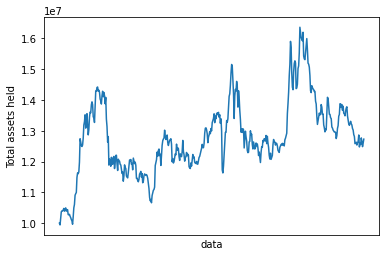

In [23]:
# 每日收益
profit = strats[0].profit
#print(profit)

# 对应日期
date = qm.get_trade_date(start_date, end_date)
# print(date)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(date, profit)
plt.xlabel("data")
plt.ylabel("Total assets held")
plt.xticks([])